# **JATIN PRASAD** 
# **Task 2.1 - Damage Classifer** 

# **CONTENTS**
* **Importing Libraries**
* **Defining Image Paths**
* **Dataset Exploration**
* **Data Augmentation and Visualization**
* **Defining the Model**
* **Plot Metrics**
* **Prediction**

## **Importing Necessary Libraries** 

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import transforms
from torch.optim import Adam
from torch.autograd import Variable
import pathlib

## **DEFINING IMAGE PATHS**

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE  
IMG_SIZE = 150
BATCH_SIZE = 32
EPOCHS = 50

DATA_DIR = '/content/drive/MyDrive/data1a'
train_dir = os.path.join(DATA_DIR, '/content/drive/MyDrive/data1a/training')
test_dir = os.path.join(DATA_DIR, '/content/drive/MyDrive/data1a/validation')

# Attempt at deterministic outputs(Reproducibility)
def seed_it_all(seed=7):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    #rng = np.random.default_rng(seed)
    
seed_it_all()

## **DATASET EXPLORATION** 

In [5]:
num_train_damaged = len(os.listdir('/content/drive/MyDrive/data1a/training/00-damage'))
num_train_whole = len(os.listdir('/content/drive/MyDrive/data1a/training/01-whole'))

print("Number of damaged train images:{}".format(num_train_damaged))
print("Number of whole train images:{}".format(num_train_whole))
print("Total train images:{}".format(num_train_damaged + num_train_whole))

print('\n')

num_test_damaged = len(os.listdir('/content/drive/MyDrive/data1a/validation/00-damage'))
num_test_whole = len(os.listdir('/content/drive/MyDrive/data1a/validation/01-whole'))

print("Number of damaged test images:{}".format(num_test_damaged))
print("Number of whole test images:{}".format(num_test_whole))
print("Total test images:{}".format(num_test_damaged + num_test_whole))

Number of damaged train images:920
Number of whole train images:920
Total train images:1840


Number of damaged test images:230
Number of whole test images:230
Total test images:460


###**Dataset is balanced between both classes, in both the train and test sets.**

### **Images from the dataset of Both kind if images i.e Whole and Damaged**

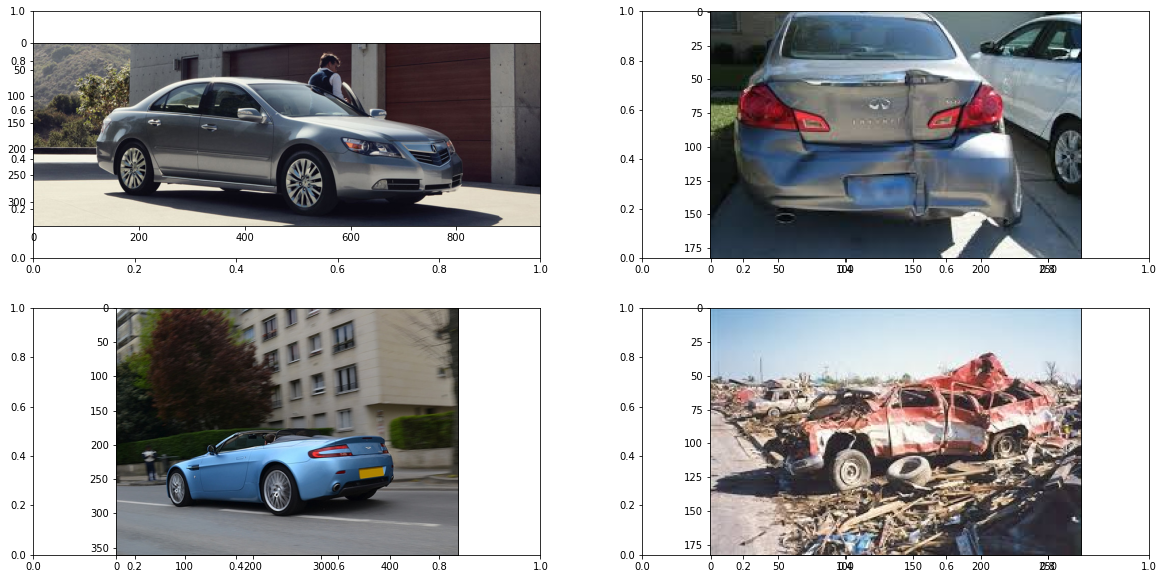

In [11]:
fig,ax=plt.subplots(nrows=2,ncols=2,figsize=(20,10))
im1=cv2.imread("/content/drive/MyDrive/data1a/training/01-whole/0007.jpg")
fig.add_subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))
im2=cv2.imread("/content/drive/MyDrive/data1a/training/00-damage/0006.JPEG")
fig.add_subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))
im3=cv2.imread("/content/drive/MyDrive/data1a/validation/01-whole/0009.jpg")
fig.add_subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(im3, cv2.COLOR_BGR2RGB))
im4=cv2.imread("/content/drive/MyDrive/data1a/validation/00-damage/0006.JPEG")
fig.add_subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(im4, cv2.COLOR_BGR2RGB))

## **Data Augmentation:**

### **Normalization and data augumentation using ImageDataGenerator below.**

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255,
                                  rotation_range=40,
                                  width_shift_range=0.4,
                                  height_shift_range=0.4,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1/255)

train_dataset = train_datagen.flow_from_directory(train_dir,
                                          target_size=(IMG_SIZE,IMG_SIZE),
                                          batch_size = BATCH_SIZE,
                                          class_mode = 'binary')
                                         
test_dataset = test_datagen.flow_from_directory(test_dir,
                                          target_size=(IMG_SIZE,IMG_SIZE),
                                          batch_size = BATCH_SIZE,
                                          class_mode = 'binary')

test_dataset.class_indices

Found 1840 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


{'00-damage': 0, '01-whole': 1}

## **DEFINING THE MODEL** 

In [13]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout, Conv2D, MaxPool2D
from keras.callbacks import EarlyStopping, ModelCheckpoint

#CNN Model 
model = Sequential()

# Convolutional layer and maxpool layer 1
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(MaxPool2D(2,2))

# Convolutional layer and maxpool layer 2
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))

# Convolutional layer and maxpool layer 3
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))

# Convolutional layer and maxpool layer 4
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))

# flattens the resulting image array to 1D array
model.add(keras.layers.Flatten())

# Hidden layer and Rectified Linear Unit activation function 
model.add(Dense(512,activation='relu'))

# Output layer with single neuron
# Using sigmoid so as our model output is between 0 and 1
# with 0 - damage car & 1 - not damage car
model.add(Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [14]:
from keras import backend as K


def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))
    
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[precision, recall, accuracy])

earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1, min_delta=0.001)
modelcheck = ModelCheckpoint('best_model.hdf5', monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')

In [16]:
history = model.fit(train_dataset, 
                    validation_data=test_dataset,
                    epochs=20,
                    callbacks=[earlystop,modelcheck],
                    batch_size=32)

Epoch 1/20
58/58 [==============================] - ETA: 0s - loss: 0.7045 - precision: 0.3801 - recall: 0.6940 - accuracy: 0.5086
Epoch 1: val_accuracy improved from -inf to 0.50486, saving model to best_model.hdf5
58/58 [==============================] - 551s 10s/step - loss: 0.7045 - precision: 0.3801 - recall: 0.6940 - accuracy: 0.5086 - val_loss: 0.6858 - val_precision: 0.5005 - val_recall: 1.0000 - val_accuracy: 0.5049
Epoch 2/20
58/58 [==============================] - ETA: 0s - loss: 0.6902 - precision: 0.3619 - recall: 0.2163 - accuracy: 0.5124
Epoch 2: val_accuracy improved from 0.50486 to 0.61528, saving model to best_model.hdf5
58/58 [==============================] - 95s 2s/step - loss: 0.6902 - precision: 0.3619 - recall: 0.2163 - accuracy: 0.5124 - val_loss: 0.6824 - val_precision: 0.6364 - val_recall: 0.5020 - val_accuracy: 0.6153
Epoch 3/20
58/58 [==============================] - ETA: 0s - loss: 0.6842 - precision: 0.5992 - recall: 0.5373 - accuracy: 0.5603
Epoch 3: v

## **Plot Metrics**

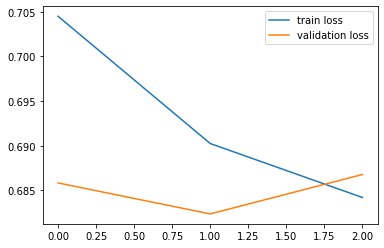

In [17]:
plt.plot(history.history['loss'], label='train loss') 
plt.plot(history.history['val_loss'], label='validation loss') 
plt.legend()
plt.show()

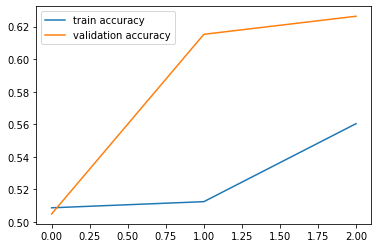

In [18]:
plt.plot(history.history['accuracy'], label='train accuracy') 
plt.plot(history.history['val_accuracy'], label='validation accuracy') 
plt.legend()
plt.show()

In [19]:
print('Validation accuracy achieved', history.history['val_accuracy'][-2])

Validation accuracy achieved 0.6152778267860413


## EVALUATE MODEL 

In [20]:
def predictImage(filename):
    
    img = cv2.imread(filename)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    plt.imshow(img)
    
    Y = np.array(img)
    X = np.expand_dims(Y,axis=0)
    val = model.predict(X)
    print(val)
    if val < 0.5:
        plt.xlabel("Car Damaged",fontsize=30)
    elif val >= 0.5:
        plt.xlabel("Car Not Damaged",fontsize=30)

[[1.]]


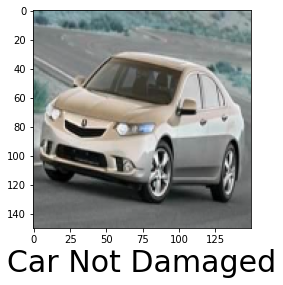

In [21]:
predictImage("/content/drive/MyDrive/data1a/validation/01-whole/0007.jpg")